# Decoding through the epoch's window time the sentence / constituent embeddings

We:

- Calculate the embeddings for each sentence / constituent

- Decode it on the epoch window

- Plot it for each condition (level / start)


Todo: 

Integrate this:

```sent_starts = epochs['word_id==0'].apply_baseline((-.300, 0.))
sent_starts.average().plot()

sent_stops = epochs['is_last_word']
bsl = (epochs.times>-.300 )*(epochs.times<=0)
baseline_starts = sent_starts.get_data()[:, :, bsl].mean(-2)

sent_stop_data = sent_stops.get_data()
n_sentences, n_channels, n_times = sent_stop_data.shape
sent_stop_data -= baseline_starts[:, :, None]```


In [ ]:
from dataset import read_raw, get_subjects, get_path, add_embeddings
from utils import decod_xy, mne_events
import mne
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import match_list
import spacy

modality = "auditory"
nlp = spacy.load("fr_core_news_sm")
all_evos = []
all_scores = []
path = get_path(modality)
subjects = get_subjects(path)
runs = 9
epoch_windows = {"word": {"onset_min": -0.3, "onset_max": 1.0, "offset_min": -1.0, "offset_max": 0.3},
                  "constituent": {"offset_min": -2.0, "offset_max": 0.5, "onset_min": -0.5, "onset_max": 2.0},
                  "sentence": {"offset_min": -4.0, "offset_max": 1.0, "onset_min": -1.0, "onset_max": 4.0}}
levels = ('word','constituent','sentence')
starts = ('onset', 'offset')
      
# Iterate on subjects to epochs, and mean later
for subject in subjects[2:10]:
    
    dict_epochs = dict() # DICT containing epochs grouped by conditions (start x level)
    
    # Initialization of the dictionary
    for start in starts: 
            for level in levels:
                epoch_key = f'{level}_{start}'
                dict_epochs[epoch_key] = [] 
                
    # Iterating on runs, building the metadata and re-epoching
    for run in range(1,runs+1):
        raw, meta_, events = read_raw(subject, run, events_return = True, modality=modality)
        meta = meta_.copy()
        
        # Metadata update
        meta['word_onset'] = True
        meta['word_stop'] = meta.start + meta.duration
        meta['sentence_onset'] = meta.word_id == 0
        meta['prev_closing'] = meta['n_closing'].shift(1)
        meta['constituent_onset'] = meta.apply(lambda x: x['prev_closing'] > x['n_closing'] and x['n_closing'] == 1, axis=1)
        meta['constituent_onset'].fillna(False, inplace=True)
        meta.drop('prev_closing', axis=1, inplace=True)
        
        # Adding the sentence stop info
        meta['sentence_id'] = np.cumsum(meta.sentence_onset)
        for s, d in meta.groupby('sentence_id'):
            meta.loc[d.index, 'sent_word_id'] = range(len(d))
            meta.loc[d.index, 'sentence_start'] = d.start.min()
            meta.loc[d.index, 'sentence_stop'] = d.start.max()
            
        # Adding the constituents stop info
        meta['constituent_id'] = np.cumsum(meta.constituent_onset)
        for s, d in meta.groupby('constituent_id'):
            meta.loc[d.index, 'constituent_start'] = d.start.min()
            meta.loc[d.index, 'constituent_stop'] = d.start.max()
            meta.loc[d.index, 'const_word_id'] = range(len(d))
        
        # Adding embeddings info
        meta = add_embeddings(meta, run, 'constituent')
        meta = add_embeddings(meta, run, 'sentence')
        
        embeddings = meta.word.apply(lambda word: nlp(word).vector).values
        meta['embeds_word'] = embeddings
        for start in starts: 
            for level in levels:
                # Select only the rows containing the True for the conditions
                # Simplified to only get for the onset: sentence onset epochs, constituent onset epochs,etc
                sel = meta.query(f'{level}_onset==True')
                assert sel.shape[0] > 10  #
                
                # Do we need to do that ???
                """
                # Matchlist events and meta
                # So that we can epoch now that's we've sliced our metadata
                if modality == 'auditory':
                    word_events = events[events[:, 2] > 1]
                    meg_delta = np.round(np.diff(word_events[:, 0]/raw.info['sfreq']))
                    meta_delta = np.round(np.diff(sel.onset.values))
                    i, j = match_list(meg_delta, meta_delta)

                # For auditory, we match on the time difference between triggers
                elif modality == "visual":

                    i, j = match_list(events[:, 2], sel.wlength)
                    assert len(i) > (0.9 * len(events))
                    assert (events[i, 2] == sel.loc[j].wlength).mean() > 0.95
                sel = sel.reset_index().loc[j]
                # Making sure there is not hidden bug when matching
                assert sel.shape[0] > 0.5 *  (meta.query(f'{level}_onset==True')).shape[0]
                """
                
                # Epoching from the metadata having all onset events: if the start=Offset, the mne events
                # Function will epoch on the offset of each level instead of the onset
                # TODO: add adaptative baseline
                epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
                                     tmin = epoch_windows[f'{level}'][f'{start}_min'],
                                       tmax = epoch_windows[f'{level}'][f'{start}_max'],
                                         event_repeated = 'drop',
                                            preload=True,
                                                baseline=None)
                epoch_key = f'{level}_{start}'

                dict_epochs[epoch_key].append(epochs)
            
    # Once we have the dict of epochs per condition full (epoching for each run for a subject)
    # we can concatenate them, and fix the dev_head             
    for start_ in starts: 
        for level_ in levels:
            epoch_key = f'{level_}_{start_}'
            all_epochs_chosen = dict_epochs[epoch_key]
            # Concatenate epochs

            for epo in all_epochs_chosen:
                epo.info["dev_head_t"] = all_epochs_chosen[1].info["dev_head_t"]

            dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)
            
    # All epochs -> Decoding and generate evoked potentials
    for start in starts: 
        for level in levels:
            epoch_key = f'{level}_{start}'
            epochs = dict_epochs[epoch_key]
            # mean
            evo = epochs.copy().pick_types(meg=True).average(method='median')
            all_evos.append(dict(subject=subject, evo=evo, start=start, level=level))


            # decoding word emb
            epochs = epochs.load_data().pick_types(meg=True, stim=False, misc=False)
            X = epochs.get_data()
            embeddings = epochs.metadata[f'embeds_{level}']
            embeddings = np.vstack(embeddings.values)
            #embeddings = epochs.metadata.word.apply(lambda word: nlp(word).vector).values
            #embeddings = np.array([emb for emb in embeddings])
            R_vec = decod_xy(X, embeddings)
            scores = np.mean(R_vec, axis=1)

            for t, score in enumerate(scores):
                all_scores.append(dict(subject=subject, score=score, start=start, level=level, t=epochs.times[t]))

all_scores = pd.DataFrame(all_scores)
all_evos = pd.DataFrame(all_evos)

all_scores.to_csv('./score.csv')
all_evos.to_csv('./evos.csv')

Reading raw files for modality: auditory

 Epoching for run 1, subject: 3

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-3/ses-01/meg/sub-3_ses-01_task-listen_run-01_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 28000 ... 658999 =     28.000 ...   658.999 secs
Ready.
Rea

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1954 events found
Event IDs: [  1 129]
Reading 0 ... 630999  =      0.000 ...   630.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:   13.2s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1597 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1597 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
484 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 484 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
155 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 155 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1595 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1595 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
492 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 492 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
158 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 158 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 2, subject: 3

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-3/ses-01/meg/sub-3_ses-01_task-listen_run-02_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 120000 ... 772999 =    120.000 ...   7

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1769 events found
Event IDs: [  1 129]
Reading 0 ... 652999  =      0.000 ...   652.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    8.2s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1765 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1765 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
510 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 510 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
141 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 141 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1757 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1757 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
523 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 523 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
147 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 147 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 3, subject: 3

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-3/ses-01/meg/sub-3_ses-01_task-listen_run-03_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 226000 ... 941999 =    226.000 ...   9

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1862 events found
Event IDs: [  1 129]
Reading 0 ... 715999  =      0.000 ...   715.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    9.3s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1849 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1849 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
566 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 566 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
183 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 183 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1843 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1843 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
577 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 577 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
189 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 189 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 4, subject: 3

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-3/ses-01/meg/sub-3_ses-01_task-listen_run-04_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 13000 ... 645999 =     13.000 ...   64

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1642 events found
Event IDs: [  1 129]
Reading 0 ... 632999  =      0.000 ...   632.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    7.8s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1637 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1637 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
513 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 513 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
153 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 153 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1627 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1627 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
518 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 518 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
157 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 157 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 5, subject: 3

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-3/ses-01/meg/sub-3_ses-01_task-listen_run-05_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 91000 ... 687999 =     91.000 ...   68

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1521 events found
Event IDs: [  1 129]
Reading 0 ... 596999  =      0.000 ...   596.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    7.8s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1514 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1514 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
472 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 472 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
175 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 175 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1509 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1509 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
478 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 478 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
179 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 179 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 6, subject: 3

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-3/ses-01/meg/sub-3_ses-01_task-listen_run-06_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 432000 ... 1193999 =    432.000 ...  1

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1846 events found
Event IDs: [  1 129]
Reading 0 ... 761999  =      0.000 ...   761.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:   10.0s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1833 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1833 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
541 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 541 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
189 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 189 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1825 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1825 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
546 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 546 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
194 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 194 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 7, subject: 3

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-3/ses-01/meg/sub-3_ses-01_task-listen_run-07_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 194000 ... 864999 =    194.000 ...   8

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1697 events found
Event IDs: [  1 129]
Reading 0 ... 670999  =      0.000 ...   670.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    9.2s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1690 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1690 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
547 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 547 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
182 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 182 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1683 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1683 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
561 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 561 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
190 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 190 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 8, subject: 3

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-3/ses-01/meg/sub-3_ses-01_task-listen_run-08_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 148000 ... 746999 =    148.000 ...   7

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1517 events found
Event IDs: [  1 129]
Reading 0 ... 598999  =      0.000 ...   598.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    7.8s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1513 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1513 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
450 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 450 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
154 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 154 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1505 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1505 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
467 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 467 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
158 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 158 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 9, subject: 3

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-3/ses-01/meg/sub-3_ses-01_task-listen_run-09_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 194000 ... 870999 =    194.000 ...   8

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1798 events found
Event IDs: [  1 129]
Reading 0 ... 676999  =      0.000 ...   676.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:   16.6s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1794 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1794 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
570 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 570 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
196 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 196 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1782 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1782 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
580 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 580 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
201 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 201 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


Adding metadata with 31 columns
15183 matching events found
No baseline correction applied
Adding metadata with 31 columns
4644 matching events found


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


No baseline correction applied
Adding metadata with 31 columns
1519 matching events found
No baseline correction applied


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)
/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


Adding metadata with 31 columns
15117 matching events found
No baseline correction applied


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


Adding metadata with 31 columns
4742 matching events found
No baseline correction applied
Adding metadata with 31 columns
1572 matching events found
No baseline correction applied


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


......................................................................................................................................................................................Reading raw files for modality: auditory

 Epoching for run 1, subject: 4

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-4/ses-01/meg/sub-4_ses-01_task-listen_run-01_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1616 events found
Event IDs: [  1 128]
Reading 0 ... 625999  =      0.000 ...   625.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    7.0s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1606 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1606 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
482 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 482 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
154 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 154 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1602 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1602 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
492 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 492 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
158 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 158 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 2, subject: 4

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-4/ses-01/meg/sub-4_ses-01_task-listen_run-02_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 15000 ... 666999 =     15.000 ...   66

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1770 events found
Event IDs: [  1 128]
Reading 0 ... 651999  =      0.000 ...   651.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    7.8s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1764 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1764 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
510 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 510 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
141 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 141 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1758 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1758 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
523 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 523 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
147 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 147 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 3, subject: 4

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-4/ses-01/meg/sub-4_ses-01_task-listen_run-03_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 8000 ... 714999 =      8.000 ...   714

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1863 events found
Event IDs: [  1 128]
Reading 0 ... 706999  =      0.000 ...   706.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    8.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1854 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1854 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
566 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 566 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
183 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 183 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1848 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1848 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
577 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 577 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
189 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 189 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 4, subject: 4

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-4/ses-01/meg/sub-4_ses-01_task-listen_run-04_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 8000 ... 641999 =      8.000 ...   641

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1643 events found
Event IDs: [  1 128]
Reading 0 ... 633999  =      0.000 ...   633.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.8s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1637 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1637 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
513 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 513 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
153 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 153 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1628 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1628 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
518 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 518 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
157 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 157 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 5, subject: 4

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-4/ses-01/meg/sub-4_ses-01_task-listen_run-05_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 11000 ... 598999 =     11.000 ...   59

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1522 events found
Event IDs: [  1 128]
Reading 0 ... 587999  =      0.000 ...   587.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    9.0s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1518 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1518 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
472 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 472 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
175 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 175 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1508 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1508 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
478 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 478 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
179 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 179 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 6, subject: 4

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-4/ses-01/meg/sub-4_ses-01_task-listen_run-06_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 10000 ... 768999 =     10.000 ...   76

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1847 events found
Event IDs: [  1 128]
Reading 0 ... 758999  =      0.000 ...   758.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:   10.0s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1845 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1845 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
542 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 542 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
191 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 191 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1835 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1835 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
546 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 546 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
194 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 194 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 7, subject: 4

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-4/ses-01/meg/sub-4_ses-01_task-listen_run-07_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 11000 ... 676999 =     11.000 ...   67

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1698 events found
Event IDs: [  1 128]
Reading 0 ... 665999  =      0.000 ...   665.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:   10.4s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1693 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1693 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
547 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 547 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
182 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 182 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1681 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1681 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
561 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 561 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
190 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 190 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 8, subject: 4

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-4/ses-01/meg/sub-4_ses-01_task-listen_run-08_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 12000 ... 609999 =     12.000 ...   60

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1518 events found
Event IDs: [  1 128]
Reading 0 ... 597999  =      0.000 ...   597.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:   10.6s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1516 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1516 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
451 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 451 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
155 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 155 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1511 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1511 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
467 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 467 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
158 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 158 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 9, subject: 4

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-4/ses-01/meg/sub-4_ses-01_task-listen_run-09_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 11000 ... 683999 =     11.000 ...   68

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1798 events found
Event IDs: [  1 128]
Reading 0 ... 672999  =      0.000 ...   672.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:   15.2s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1792 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1792 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
570 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 570 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
196 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 196 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1783 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1783 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
580 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 580 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
201 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 201 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


Adding metadata with 31 columns
15216 matching events found
No baseline correction applied


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


Adding metadata with 31 columns
4644 matching events found
No baseline correction applied
Adding metadata with 31 columns
1521 matching events found
No baseline correction applied


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)
/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


Adding metadata with 31 columns
15145 matching events found
No baseline correction applied


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


Adding metadata with 31 columns
4742 matching events found
No baseline correction applied
Adding metadata with 31 columns
1572 matching events found
No baseline correction applied


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


......................................................................................................................................................................................Reading raw files for modality: auditory

 Epoching for run 1, subject: 5

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-5/ses-01/meg/sub-5_ses-01_task-listen_run-01_meg.fif...
    Read a total of 13 projection items:
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1709 events found
Event IDs: [  1 128]
Reading 0 ... 617999  =      0.000 ...   617.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1601 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1601 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
489 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 489 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
158 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 158 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1596 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1596 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
492 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 492 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
158 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 158 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 2, subject: 5

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-5/ses-01/meg/sub-5_ses-01_task-listen_run-02_meg.fif...
    Read a total of 13 projection items:
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
    Range : 15000 ... 667999 =     15.000 ...   667.999 secs
Ready.
Reading events from /home/is153802/data

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)


Reading channel info from /home/is153802/data/LPP_MEG_auditory/sub-5/ses-01/meg/sub-5_ses-01_task-listen_run-02_channels.tsv.
Using 4 HPI coils: 293 307 314 321 Hz
Not fully anonymizing info - keeping his_id, sex, and hand info


/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1895 events found
Event IDs: [  1 128]
Reading 0 ... 652999  =      0.000 ...   652.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    7.9s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1771 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1771 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
519 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 519 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
147 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 147 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1766 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1766 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
523 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 523 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
147 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 147 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 3, subject: 5

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-5/ses-01/meg/sub-5_ses-01_task-listen_run-03_meg.fif...
    Read a total of 13 projection items:
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
    Range : 8000 ... 715999 =      8.000 ...   715.999 secs
Ready.
Reading events from /home/is153802/data/

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1983 events found
Event IDs: [  1 128]
Reading 0 ... 707999  =      0.000 ...   707.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    8.5s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1839 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1839 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
570 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 570 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
186 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 186 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1836 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1836 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
577 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 577 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
189 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 189 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 4, subject: 5

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-5/ses-01/meg/sub-5_ses-01_task-listen_run-04_meg.fif...
    Read a total of 13 projection items:
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
    Range : 10000 ... 639999 =     10.000 ...   639.999 secs
Ready.
Reading events from /home/is153802/data

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1780 events found
Event IDs: [  1 128]
Reading 0 ... 629999  =      0.000 ...   629.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1628 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1628 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
516 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 516 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
157 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 157 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1625 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1625 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
518 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 518 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
157 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 157 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 5, subject: 5

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-5/ses-01/meg/sub-5_ses-01_task-listen_run-05_meg.fif...
    Read a total of 13 projection items:
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
    Range : 12000 ... 596999 =     12.000 ...   596.999 secs
Ready.
Reading events from /home/is153802/data

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1625 events found
Event IDs: [  1 128]
Reading 0 ... 584999  =      0.000 ...   584.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    7.0s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1512 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1512 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
478 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 478 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
179 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 179 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1507 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1507 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
478 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 478 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
179 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 179 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 6, subject: 5

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-5/ses-01/meg/sub-5_ses-01_task-listen_run-06_meg.fif...
    Read a total of 13 projection items:
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
    Range : 10000 ... 765999 =     10.000 ...   765.999 secs
Ready.
Reading events from /home/is153802/data

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1968 events found
Event IDs: [  1 128]
Reading 0 ... 755999  =      0.000 ...   755.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    9.1s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1836 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1836 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
545 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 545 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
194 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 194 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1830 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1830 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
546 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 546 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
194 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 194 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 7, subject: 5

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-5/ses-01/meg/sub-5_ses-01_task-listen_run-07_meg.fif...
    Read a total of 13 projection items:
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
    Range : 11000 ... 672999 =     11.000 ...   672.999 secs
Ready.
Reading events from /home/is153802/data

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1824 events found
Event IDs: [  1 128]
Reading 0 ... 661999  =      0.000 ...   661.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    8.0s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1686 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1686 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
554 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 554 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
186 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 186 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1684 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1684 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
561 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 561 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
190 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 190 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 8, subject: 5

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-5/ses-01/meg/sub-5_ses-01_task-listen_run-08_meg.fif...
    Read a total of 13 projection items:
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
    Range : 12000 ... 599999 =     12.000 ...   599.999 secs
Ready.
Reading events from /home/is153802/data

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1621 events found
Event IDs: [  1 128]
Reading 0 ... 587999  =      0.000 ...   587.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    7.1s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1512 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1512 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
459 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 459 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
156 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 156 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1509 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1509 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
467 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 467 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
158 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 158 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 9, subject: 5

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-5/ses-01/meg/sub-5_ses-01_task-listen_run-09_meg.fif...
    Read a total of 13 projection items:
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
    Range : 11000 ... 681999 =     11.000 ...   681.999 secs
Ready.
Reading events from /home/is153802/data

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1935 events found
Event IDs: [  1 128]
Reading 0 ... 670999  =      0.000 ...   670.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    8.4s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1785 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1785 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
574 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 574 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 200 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1777 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1777 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
580 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 580 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
201 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 201 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


Adding metadata with 31 columns
15161 matching events found
No baseline correction applied


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


Adding metadata with 31 columns
4695 matching events found
No baseline correction applied
Adding metadata with 31 columns
1556 matching events found
No baseline correction applied


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)
/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


Adding metadata with 31 columns
15121 matching events found
No baseline correction applied


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


Adding metadata with 31 columns
4742 matching events found
No baseline correction applied
Adding metadata with 31 columns
1571 matching events found
No baseline correction applied


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


......................................................................................................................................................................................Reading raw files for modality: auditory

 Epoching for run 1, subject: 6

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-6/ses-01/meg/sub-6_ses-01_task-listen_run-01_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1616 events found
Event IDs: [  1 128]
Reading 0 ... 616999  =      0.000 ...   616.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.9s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1609 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1609 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
482 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 482 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
154 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 154 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1604 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1604 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
492 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 492 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
158 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 158 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 2, subject: 6

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-6/ses-01/meg/sub-6_ses-01_task-listen_run-02_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 20000 ... 670999 =     20.000 ...   67

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1770 events found
Event IDs: [  1 128]
Reading 0 ... 650999  =      0.000 ...   650.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    7.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1768 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1768 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
511 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 511 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
141 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 141 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1762 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1762 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
523 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 523 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
147 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 147 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 3, subject: 6

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-6/ses-01/meg/sub-6_ses-01_task-listen_run-03_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 10000 ... 717999 =     10.000 ...   71

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1863 events found
Event IDs: [  1 128]
Reading 0 ... 707999  =      0.000 ...   707.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    8.3s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1854 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1854 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
567 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 567 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
184 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 184 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1847 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1847 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
577 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 577 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
189 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 189 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 4, subject: 6

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-6/ses-01/meg/sub-6_ses-01_task-listen_run-04_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 12000 ... 644999 =     12.000 ...   64

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1643 events found
Event IDs: [  1 128]
Reading 0 ... 632999  =      0.000 ...   632.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.6s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1639 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1639 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
513 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 513 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
154 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 154 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1629 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1629 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
518 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 518 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
157 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 157 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 5, subject: 6

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-6/ses-01/meg/sub-6_ses-01_task-listen_run-05_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 30000 ... 617999 =     30.000 ...   61

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1522 events found
Event IDs: [  1 128]
Reading 0 ... 587999  =      0.000 ...   587.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.9s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1517 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1517 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
473 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 473 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
175 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 175 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1509 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1509 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
478 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 478 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
179 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 179 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 6, subject: 6

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-6/ses-01/meg/sub-6_ses-01_task-listen_run-06_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 9000 ... 767999 =      9.000 ...   767

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1847 events found
Event IDs: [  1 128]
Reading 0 ... 758999  =      0.000 ...   758.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    9.8s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1836 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1836 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
541 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 541 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
190 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 190 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1830 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1830 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
546 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 546 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
194 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 194 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 7, subject: 6

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-6/ses-01/meg/sub-6_ses-01_task-listen_run-07_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 11000 ... 678999 =     11.000 ...   67

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1698 events found
Event IDs: [  1 128]
Reading 0 ... 667999  =      0.000 ...   667.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    9.0s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1693 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1693 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
549 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 549 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
183 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 183 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1681 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1681 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
561 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 561 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
190 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 190 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 8, subject: 6

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-6/ses-01/meg/sub-6_ses-01_task-listen_run-08_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 10000 ... 604999 =     10.000 ...   60

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1518 events found
Event IDs: [  1 128]
Reading 0 ... 594999  =      0.000 ...   594.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    7.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1512 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1512 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
450 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 450 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
154 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 154 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1508 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1508 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
467 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 467 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
158 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 158 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 9, subject: 6

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-6/ses-01/meg/sub-6_ses-01_task-listen_run-09_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 11000 ... 689999 =     11.000 ...   68

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1799 events found
Event IDs: [  1 128]
Reading 0 ... 678999  =      0.000 ...   678.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    9.3s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1791 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1791 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
569 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 569 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
195 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 195 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1784 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1784 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
580 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 580 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
201 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 201 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


Adding metadata with 31 columns
15210 matching events found
No baseline correction applied


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


Adding metadata with 31 columns
4646 matching events found
No baseline correction applied
Adding metadata with 31 columns
1521 matching events found
No baseline correction applied


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)
/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


Adding metadata with 31 columns
15145 matching events found
No baseline correction applied


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


Adding metadata with 31 columns
4742 matching events found
No baseline correction applied
Adding metadata with 31 columns
1573 matching events found
No baseline correction applied


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


......................................................................................................................................................................................Reading raw files for modality: auditory

 Epoching for run 1, subject: 7

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-7/ses-01/meg/sub-7_ses-01_task-listen_run-01_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1616 events found
Event IDs: [  1 128]
Reading 0 ... 621999  =      0.000 ...   621.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.5s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1613 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1613 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
482 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 482 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
154 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 154 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1606 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1606 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
492 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 492 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
158 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 158 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 2, subject: 7

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-7/ses-01/meg/sub-7_ses-01_task-listen_run-02_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 358000 ... 1018999 =    358.000 ...  1

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1770 events found
Event IDs: [  1 128]
Reading 0 ... 660999  =      0.000 ...   660.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    7.6s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1767 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1767 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
511 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 511 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
141 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 141 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1756 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1756 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
523 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 523 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
147 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 147 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 3, subject: 7

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-7/ses-01/meg/sub-7_ses-01_task-listen_run-03_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 61000 ... 776999 =     61.000 ...   77

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1863 events found
Event IDs: [  1 128]
Reading 0 ... 715999  =      0.000 ...   715.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    8.3s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1858 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1858 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
568 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 568 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
185 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 185 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1849 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1849 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
577 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 577 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
189 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 189 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 4, subject: 7

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-7/ses-01/meg/sub-7_ses-01_task-listen_run-04_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 301000 ... 935999 =    301.000 ...   9

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1643 events found
Event IDs: [  1 128]
Reading 0 ... 634999  =      0.000 ...   634.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.5s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1635 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1635 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
512 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 512 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
152 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 152 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1627 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1627 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
518 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 518 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
157 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 157 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 5, subject: 7

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-7/ses-01/meg/sub-7_ses-01_task-listen_run-05_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 210000 ... 826999 =    210.000 ...   8

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1522 events found
Event IDs: [  1 128]
Reading 0 ... 616999  =      0.000 ...   616.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.6s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1516 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1516 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
472 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 472 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
175 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 175 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1509 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1509 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
478 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 478 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
179 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 179 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 6, subject: 7

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-7/ses-01/meg/sub-7_ses-01_task-listen_run-06_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 421000 ... 1181999 =    421.000 ...  1

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1847 events found
Event IDs: [  1 128]
Reading 0 ... 760999  =      0.000 ...   760.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    9.3s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1845 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1845 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
542 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 542 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
191 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 191 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1835 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1835 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
546 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 546 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
194 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 194 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 7, subject: 7

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-7/ses-01/meg/sub-7_ses-01_task-listen_run-07_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 256000 ... 931999 =    256.000 ...   9

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1698 events found
Event IDs: [  1 128]
Reading 0 ... 675999  =      0.000 ...   675.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    8.3s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1694 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1694 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
547 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 547 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
183 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 183 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1682 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1682 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
561 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 561 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
190 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 190 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 8, subject: 7

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-7/ses-01/meg/sub-7_ses-01_task-listen_run-08_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 273000 ... 871999 =    273.000 ...   8

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1518 events found
Event IDs: [  1 128]
Reading 0 ... 598999  =      0.000 ...   598.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    7.4s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1511 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1511 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
449 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 449 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
153 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 153 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1505 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1505 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
467 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 467 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
158 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 158 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 9, subject: 7

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-7/ses-01/meg/sub-7_ses-01_task-listen_run-09_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 257000 ... 938999 =    257.000 ...   9

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1799 events found
Event IDs: [  1 128]
Reading 0 ... 681999  =      0.000 ...   681.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    8.5s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1789 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1789 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
570 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 570 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
196 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 196 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1780 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1780 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
580 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 580 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
201 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 201 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


Adding metadata with 31 columns
15219 matching events found
No baseline correction applied


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


Adding metadata with 31 columns
4644 matching events found
No baseline correction applied
Adding metadata with 31 columns
1521 matching events found


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


No baseline correction applied


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


Adding metadata with 31 columns
15140 matching events found
No baseline correction applied


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


Adding metadata with 31 columns
4742 matching events found
No baseline correction applied


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


Adding metadata with 31 columns
1573 matching events found
No baseline correction applied
......................................................................................................................................................................................Reading raw files for modality: auditory

 Epoching for run 1, subject: 8

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-8/ses-01/meg/sub-8_ses-01_task-listen_run-01_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1616 events found
Event IDs: [  1 128]
Reading 0 ... 626999  =      0.000 ...   626.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.6s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1611 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1611 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
482 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 482 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
154 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 154 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1604 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1604 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
492 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 492 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
158 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 158 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 2, subject: 8

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-8/ses-01/meg/sub-8_ses-01_task-listen_run-02_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 359000 ... 1021999 =    359.000 ...  1

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


2616 events found
Event IDs: [  1 128]
Reading 0 ... 662999  =      0.000 ...   662.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    8.1s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1757 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1757 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
523 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 523 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
147 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 147 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1745 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1745 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
523 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 523 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
147 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 147 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 3, subject: 8

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-8/ses-01/meg/sub-8_ses-01_task-listen_run-03_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 171000 ... 875999 =    171.000 ...   8

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1863 events found
Event IDs: [  1 128]
Reading 0 ... 704999  =      0.000 ...   704.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    8.4s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1857 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1857 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
568 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 568 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
185 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 185 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1848 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1848 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
577 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 577 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
189 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 189 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 4, subject: 8

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-8/ses-01/meg/sub-8_ses-01_task-listen_run-04_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 130000 ... 769999 =    130.000 ...   7

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1643 events found
Event IDs: [  1 128]
Reading 0 ... 639999  =      0.000 ...   639.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    7.5s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1637 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1637 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
513 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 513 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
154 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 154 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1628 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1628 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
518 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 518 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
157 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 157 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 5, subject: 8

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-8/ses-01/meg/sub-8_ses-01_task-listen_run-05_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 108000 ... 702999 =    108.000 ...   7

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1522 events found
Event IDs: [  1 128]
Reading 0 ... 594999  =      0.000 ...   594.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    7.2s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1520 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1520 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
473 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 473 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
175 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 175 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1512 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1512 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
478 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 478 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
179 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 179 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 6, subject: 8

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-8/ses-01/meg/sub-8_ses-01_task-listen_run-06_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 188000 ... 946999 =    188.000 ...   9

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1847 events found
Event IDs: [  1 128]
Reading 0 ... 758999  =      0.000 ...   758.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    9.3s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1844 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1844 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
541 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 541 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
190 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 190 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1834 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1834 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
546 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 546 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
194 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 194 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 7, subject: 8

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-8/ses-01/meg/sub-8_ses-01_task-listen_run-07_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 141000 ... 807999 =    141.000 ...   8

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1698 events found
Event IDs: [  1 128]
Reading 0 ... 666999  =      0.000 ...   666.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    8.3s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1695 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1695 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
549 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 549 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
183 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 183 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1684 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1684 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
561 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 561 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
190 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 190 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 8, subject: 8

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-8/ses-01/meg/sub-8_ses-01_task-listen_run-08_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 123000 ... 714999 =    123.000 ...   7

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1518 events found
Event IDs: [  1 128]
Reading 0 ... 591999  =      0.000 ...   591.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    7.6s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1512 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1512 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
449 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 449 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
153 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 153 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1503 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1503 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
467 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 467 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
158 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 158 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 9, subject: 8

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-8/ses-01/meg/sub-8_ses-01_task-listen_run-09_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 128000 ... 813999 =    128.000 ...   8

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1799 events found
Event IDs: [  1 128]
Reading 0 ... 685999  =      0.000 ...   685.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    8.8s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1794 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1794 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
570 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 570 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
196 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 196 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1782 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1782 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
580 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 580 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
201 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 201 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


Adding metadata with 31 columns
15218 matching events found
No baseline correction applied


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


Adding metadata with 31 columns
4660 matching events found
No baseline correction applied


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


Adding metadata with 31 columns
1529 matching events found
No baseline correction applied


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


Adding metadata with 31 columns
15131 matching events found
No baseline correction applied


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


Adding metadata with 31 columns
4742 matching events found
No baseline correction applied
Adding metadata with 31 columns
1573 matching events found
No baseline correction applied


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


......................................................................................................................................................................................Reading raw files for modality: auditory

 Epoching for run 1, subject: 9

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-9/ses-01/meg/sub-9_ses-01_task-listen_run-01_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1616 events found
Event IDs: [  1 128]
Reading 0 ... 624999  =      0.000 ...   624.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.6s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1606 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1606 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
482 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 482 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
154 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 154 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1601 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1601 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
492 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 492 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
158 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 158 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 2, subject: 9

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-9/ses-01/meg/sub-9_ses-01_task-listen_run-02_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 300000 ... 955999 =    300.000 ...   9

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1778 events found
Event IDs: [  1 128]
Reading 0 ... 655999  =      0.000 ...   655.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    7.9s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1762 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1762 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
510 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 510 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
141 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 141 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1754 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1754 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
523 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 523 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
147 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 147 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 3, subject: 9

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-9/ses-01/meg/sub-9_ses-01_task-listen_run-03_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 152000 ... 855999 =    152.000 ...   8

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1860 events found
Event IDs: [  1 128]
Reading 0 ... 703999  =      0.000 ...   703.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    8.3s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1854 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1854 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
568 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 568 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
184 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 184 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1854 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1854 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


2 bad epochs dropped
Adding metadata with 31 columns
577 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 577 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


2 bad epochs dropped
Adding metadata with 31 columns
189 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 189 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 4, subject: 9

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-9/ses-01/meg/sub-9_ses-01_task-listen_run-04_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 212000 ... 853999 =    212.000 ...   8

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1643 events found
Event IDs: [  1 128]
Reading 0 ... 641999  =      0.000 ...   641.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    7.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1635 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1635 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
512 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 512 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
152 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 152 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1627 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1627 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
518 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 518 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
157 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 157 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 5, subject: 9

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-9/ses-01/meg/sub-9_ses-01_task-listen_run-05_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 150000 ... 747999 =    150.000 ...   7

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1522 events found
Event IDs: [  1 128]
Reading 0 ... 597999  =      0.000 ...   597.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    7.1s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1516 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1516 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
472 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 472 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
175 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 175 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1508 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1508 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
478 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 478 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
179 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 179 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 6, subject: 9

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-9/ses-01/meg/sub-9_ses-01_task-listen_run-06_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 462000 ... 1223999 =    462.000 ...  1

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1847 events found
Event IDs: [  1 128]
Reading 0 ... 761999  =      0.000 ...   761.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    9.3s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1832 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1832 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
540 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 540 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
188 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 188 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1826 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1826 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
546 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 546 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
194 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 194 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 7, subject: 9

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-9/ses-01/meg/sub-9_ses-01_task-listen_run-07_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 178000 ... 877999 =    178.000 ...   8

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1698 events found
Event IDs: [  1 128]
Reading 0 ... 699999  =      0.000 ...   699.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    8.5s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1690 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1690 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
547 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 547 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
182 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 182 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1683 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1683 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
561 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 561 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
190 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 190 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 8, subject: 9

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-9/ses-01/meg/sub-9_ses-01_task-listen_run-08_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 24000 ... 618999 =     24.000 ...   61

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1518 events found
Event IDs: [  1 128]
Reading 0 ... 594999  =      0.000 ...   594.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    7.4s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1512 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1512 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
449 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 449 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
153 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 153 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1510 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1510 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
467 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 467 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
158 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 158 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Reading raw files for modality: auditory

 Epoching for run 9, subject: 9

Opening raw data file /home/is153802/data/LPP_MEG_auditory/sub-9/ses-01/meg/sub-9_ses-01_task-listen_run-09_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 314000 ... 993999 =    314.000 ...   9

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1799 events found
Event IDs: [  1 128]
Reading 0 ... 679999  =      0.000 ...   679.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    8.4s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1790 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1790 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
570 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 570 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
196 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 196 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1782 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1782 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
580 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 580 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
201 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 201 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_419902/1311283257.py:100: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


Adding metadata with 31 columns
15188 matching events found
No baseline correction applied


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


Adding metadata with 31 columns
4641 matching events found
No baseline correction applied
Adding metadata with 31 columns
1516 matching events found


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


No baseline correction applied


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


Adding metadata with 31 columns
15135 matching events found
No baseline correction applied


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


Adding metadata with 31 columns
4740 matching events found
No baseline correction applied
Adding metadata with 31 columns
1573 matching events found
No baseline correction applied


/tmp/ipykernel_419902/1311283257.py:121: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)


..................................

<Figure size 1280x800 with 0 Axes>

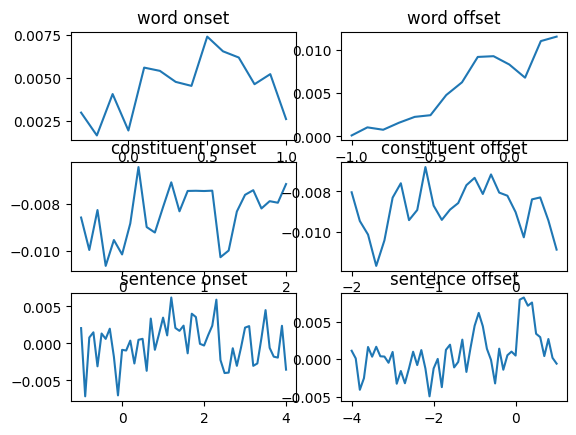

In [8]:
all_scores = pd.DataFrame(all_scores)
all_evos = pd.DataFrame(all_evos)

from matplotlib.pyplot import figure

figure(figsize=(16, 10), dpi=80)

fig, axes = plt.subplots(3, 2)

for axes_, level in zip( axes, levels):  
    for ax, start in zip( axes_, starts):  
        cond1 = all_scores.level==f'{level}'
        cond2 = all_scores.start==f'{start}'
        data = all_scores[ cond1 & cond2]
        y = []
        x = []
        for s, t in data.groupby('t'):
            score_avg = t.score.mean()
            y.append(score_avg)
            x.append(s)

        ax.plot(x,y)
        ax.set_title(f'{level} {start}')


In [6]:
for i in (tuple("hi")):
    print(i)

h
i
